In [1]:
import os 
import requests
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mimg
from PIL import Image
from LaserBeamAttack import LaserBeamAttackAadapter, LaserBeamOptimizer
from utils import LaserBeam, Line, add_images, generate_laser_image, show_NRGB_image


### Constants

In [2]:
CLASSES = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' 
}

In [3]:
IMAGE_SIZE = (32, 32)
IMAGE_SHAPE = (*IMAGE_SIZE, 3)
REAL_CLASS = 1

In [4]:
CLASSES[REAL_CLASS]

'Speed limit (30km/h)'

### Helper functions

In [5]:
def rescale_image(image: np.ndarray, desired_size=IMAGE_SIZE):
	image_uin8 = (image*255).astype(np.uint8)
	img = Image.fromarray(image_uin8).resize(IMAGE_SIZE)
	return np.array(img)/255

In [6]:
def load_image(seeken_class):
	dir_path = f"../../Models/gtsrb-german-traffic-sign/train/{seeken_class}"
	file_name = os.listdir(dir_path)[0]
	return  mimg.imread(f"{dir_path}/{file_name}")

In [7]:
def predict_image_class(image, model):
	image_expanded = np.expand_dims(image, 0)
	return model.predict(image_expanded)
	

In [8]:
def plot_results(
	real_image_and_class, 
	adversarial_image_and_class, 
	figsize=IMAGE_SIZE, 
	classes=CLASSES
):
	figure = plt.figure(figsize=figsize)
	for i, record in enumerate(
		[
			(*real_image_and_class, "Real"), 
			(*adversarial_image_and_class, "Adversarial"),
			(rescale_image(load_image(adversarial_image_and_class[1])), adversarial_image_and_class[1], "Confused with:")
		]
	):
		image, image_class_number, title = record
		image_class = classes[image_class_number]
		figure.add_subplot(1,3, i+1)
		plt.imshow(image)
		plt.title(title, fontsize=32)
		plt.xlabel(image_class, fontsize=32)
	plt.show()


In [9]:
model = tf.keras.models.load_model("sign_model2")

In [10]:
max_30_raw = mimg.imread( '../../Models/gtsrb-german-traffic-sign/Test/00001.png')

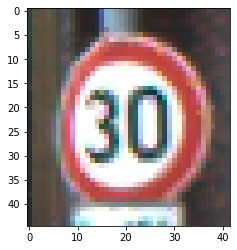

In [11]:
plt.imshow(max_30_raw)

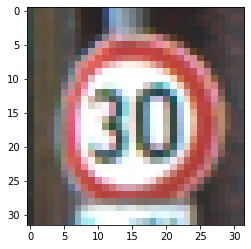

In [12]:
max_30 = rescale_image(max_30_raw)
plt.imshow(max_30)

In [13]:

max_30.shape

(32, 32, 3)

In [14]:
prediction = predict_image_class(max_30, model)

In [15]:
predicted_class = prediction.argmax()

In [16]:
CLASSES[predicted_class]

'Speed limit (30km/h)'

In [17]:
predicted_class == REAL_CLASS

True

## Time to attack

In [18]:
min_params = LaserBeam.from_numpy(np.array([380, 0, 0, 0]))
max_params = LaserBeam.from_numpy(np.array([780, 3.14, 32,32]))
optimizer = LaserBeamOptimizer(min_params, max_params)

In [19]:
attack = LaserBeamAttackAadapter(model, optimizer)

In [20]:
laser_params, adversarial_class = attack.run(
	image=max_30, 
	iterations=1,
	random_initializations=5
)

In [21]:
CLASSES[adversarial_class]

'Stop'

In [22]:
adversarial_class == REAL_CLASS

False

In [23]:
laser_params

LaserBeam(wavelength=711.500784555609, Line=Line(r=2.602281158761531, b=26.520062764448724), width=26.520062764448724)

In [24]:
adversarial_laser_image = generate_laser_image(laser_params, shape=IMAGE_SHAPE)

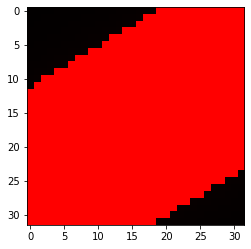

In [25]:
plt.imshow(adversarial_laser_image)

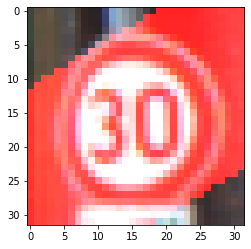

In [26]:
adversarial_image = add_images(max_30, adversarial_laser_image)
plt.imshow(adversarial_image)

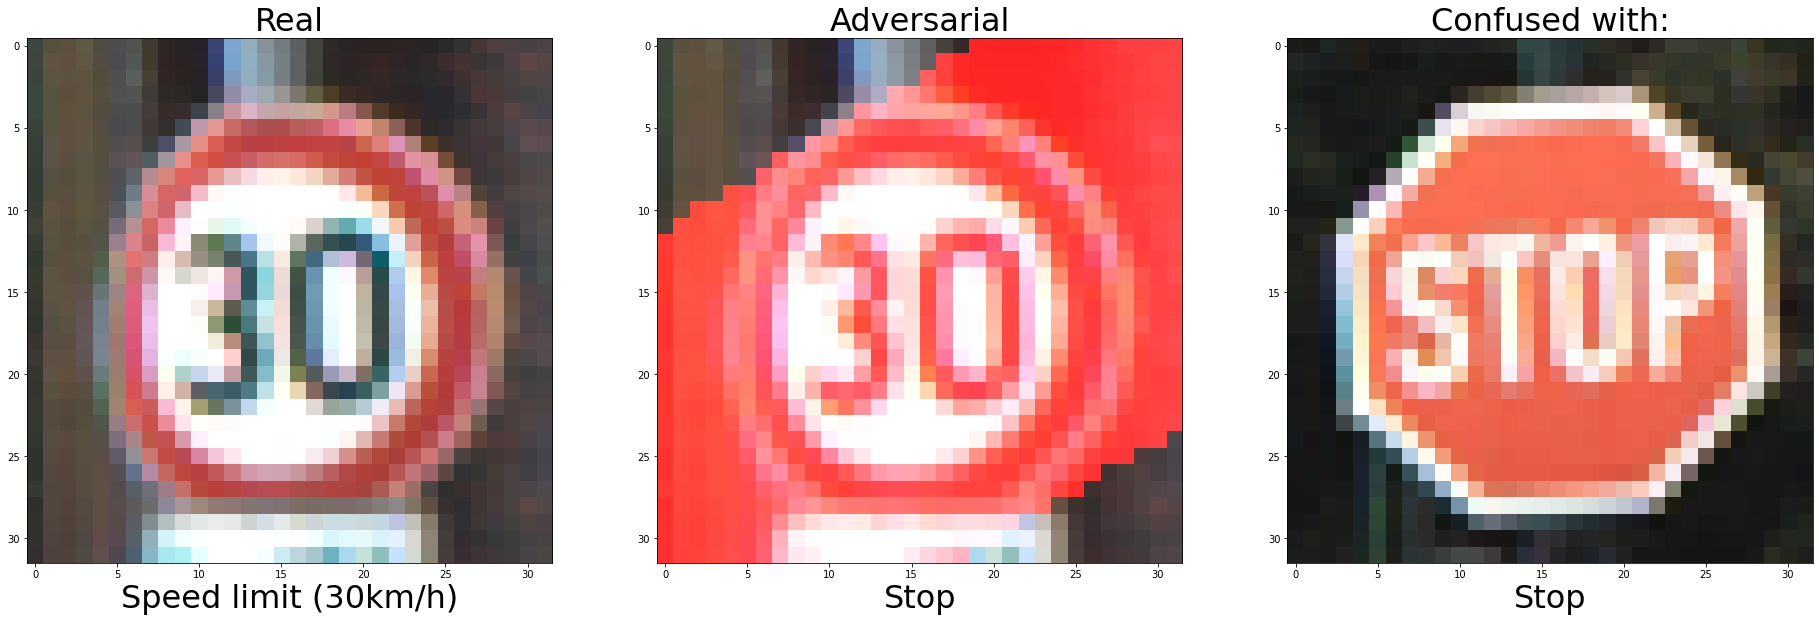

In [27]:
plot_results(
	(max_30, predicted_class),
	(adversarial_image, adversarial_class)
)

## External image

In [28]:
external_image_url = "https://thumbs.dreamstime.com/t/road-signs-main-road-sign-blue-background-road-signs-main-road-sign-blue-background-109436823.jpg"
r = requests.get(external_image_url, stream=True)

In [29]:
external_image_raw = np.array(Image.open(r.raw).convert("RGB"))/255

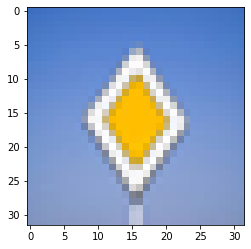

In [30]:
external_image = rescale_image(external_image_raw, IMAGE_SIZE)
plt.imshow(external_image)

In [31]:
external_image_prediction = predict_image_class(external_image, model)
external_image_class = external_image_prediction.argmax()

In [32]:
laser_params_ext, adversarial_class_ext = attack.run(
	image=external_image, 
	iterations=5,
	random_initializations=5
)

In [33]:
adv_image_ext = add_images(external_image, generate_laser_image(laser_params_ext, shape=IMAGE_SHAPE))

TypeError: 'NoneType' object is not callable

In [ ]:
plot_results(
	(external_image, CLASSES[external_image_class]),
	(adv_image_ext, CLASSES[adversarial_class_ext])
)